# Projekt 2. Deep Learning
Lizaveta Hurskaya (hurskaya@student.agh.edu.pl)
Yauheniya Padbiarozskaya (padbiaro@student.agh.edu.pl)

# Przygotowanie środowiska i funkcji pomocniczych


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras import models
from keras import layers
from keras.utils import to_categorical

In [22]:
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

In [23]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

In [24]:
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

# Przygotowanie danych

Ładowanie danych surowych

In [41]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Spłaszczenie zestawu danych

In [42]:
print("Shape of train set before flattening data: ", train_images.shape)
print("Shape of test set before flattening data: ", test_images.shape)

# 3D -> 2D
train_raw = train_images.reshape(train_images.shape[0], train_images.shape[1]**2)
print("Train set after flattening: ", train_raw.shape)

test_raw = test_images.reshape(test_images.shape[0], test_images.shape[1]**2)
print("Test set after flattening: ", test_raw.shape)

Shape of train set before flattening data:  (60000, 28, 28)
Shape of test set before flattening data:  (10000, 28, 28)
Train set after flattening:  (60000, 784)
Test set after flattening:  (10000, 784)


Spłaszczenie zbiorów danych dla obrazów wyrównanych

In [43]:
train_deskewed = np.array([deskew(im) for im in train_images])
test_deskewed = np.array([deskew(im) for im in test_images])

train_deskewed = np.asarray(train_deskewed).reshape(-1,28*28)
test_deskewed = np.asarray(test_deskewed).reshape(-1,28*28)

In [44]:
print(train_deskewed.shape)

(60000, 784)


Zastosowanie HOG na danych

In [45]:
hogdata_raw_train = np.float32([openCVHOG(im) for im in train_images]).reshape(-1, 81)
hogdata_raw_test = np.float32([openCVHOG(im) for im in test_images]).reshape(-1, 81)

hogdata_deskewed_train = np.float32([openCVHOG(deskew(im)) for im in train_images]).reshape(-1, 81)
hogdata_deskewed_test = np.float32([openCVHOG(deskew(im)) for im in test_images]).reshape(-1, 81)

In [46]:
print(hogdata_raw_train.shape)

(60000, 81)


# Przypadek bazowy dla porównywania: trening klasyfikatorów i sieci neuronowej obrazami wyrównanymi po zastosowaniu funkcji OpenCVHOG

### Support Vector Classifier

**Wybór modelu.**
 W tym miejscu i dalej stosowana jest funkcja GridSearchCV, co powoduje sprawdzanie każdego z zestawów parametrów z użyciem 5-krotnej walidacji krzyżowej. Generator walidacji krzyżowej StartifiedKFold powoduje, że podczas walidacji krzyżowej podział danych jest równomierny: w zbiorze treningowym i testowym jest taki sam stosunek liczby danych, należących do każdej z klas, do całkowitego rozmiaru zbioru.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

parameters = {
    'C' : [0.01, 0.25, 0.5, 2, 5, 15, 20, 25],
    'gamma' : [0.25, 0.5, 0.75]
}

model = SVC()
clf_svc = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_svc.fit(hogdata_deskewed_train[:1000], train_labels[:1000])
print(clf_svc.best_params_)

{'C': 2, 'gamma': 0.5}


Testowanie modelu SVC dla obrazów wyrównanych

In [ ]:
model = clf_svc.best_estimator_
model = model.fit(hogdata_deskewed_train, train_labels)
pred_labels = model.predict(hogdata_deskewed_test)

In [ ]:
mask = pred_labels==test_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

98.38
[[ 973    1    1    0    0    2    1    1    0    1]
 [   0 1128    1    0    0    0    2    4    0    0]
 [   0    1 1015    1    0    0    1   11    3    0]
 [   0    0    4  997    0    3    0    4    2    0]
 [   1    0    2    0  967    1    4    0    1    6]
 [   0    0    1    3    0  879    3    2    3    1]
 [   3    2    1    0    9    3  940    0    0    0]
 [   1    4    9    5    0    0    0 1006    2    1]
 [   0    0    3    5    6    2    0    1  945   12]
 [   2    0    1    0    5    4    1    2    6  988]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0

### Random Forest Classifier

Wybór modelu:

In [ ]:
parameters = {
    'max_depth' : [4**n for n in range(1, 5)],
    'max_features' : [10*n for n in range(1, 5)]
}
model = RandomForestClassifier()
clf_rfc = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_rfc.fit(hogdata_deskewed_train[:1000], train_labels[:1000])
print(clf_rfc.best_params_)

{'max_depth': 16, 'max_features': 10}


Testowanie modelu dla obrazów wyrównanych

In [ ]:
rfc =  clf_rfc.best_estimator_
rfc = rfc.fit(hogdata_deskewed_train,train_labels)

pred_labels = rfc.predict(hogdata_deskewed_test)

mask = pred_labels==test_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

97.03
[[ 960    0    4    0    1    3    4    2    1    5]
 [   0 1126    3    1    0    0    1    3    1    0]
 [   1    1 1007    1    0    0    4   13    3    2]
 [   0    1   14  983    0    2    0    6    2    2]
 [   1    1    0    0  955    1    8    0    2   14]
 [   4    0    0    3    0  875    1    1    5    3]
 [   7    3    0    0   10    5  928    0    4    1]
 [   4    1   26   12    0    0    0  974    5    6]
 [   0    0    2    8    7    3    3    2  929   20]
 [   5    0    1    0    4    6    3    2   22  966]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.98      0.96      1032
           3       0.98      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.98      0.98       892
           6       0.97      0.97      0.97       958
           7       0.97      0

***Wyniki klasyfikacji:***


*   SVC: 98.38%
*   Las losowy: 97.03%



### Sieć neuronowa

Przygotowanie danych dla sieci neuronowej

In [ ]:
from keras.utils import to_categorical

encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

Definiowanie sieci neuronowej

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

def create_network():
  network = Sequential()
  network.add(Dense(512, activation='relu', input_shape=(81,)))
  network.add(Dense(10, activation='softmax'))
  network.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return network

Wybór modelu

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn = create_network, epochs=5, verbose=0)

parameters = {
    'batch_size' : [4**n for n in range(1, 6)]
}

grid = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
grid_result = grid.fit(hogdata_deskewed_train[:10000], train_labels[:10000])
print(grid_result.best_params_, grid_result.best_score_)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'batch_size': 64} 0.9556999999999999


Testowanie sieci neuronowej na obrazach wyrównanych

In [ ]:
network = create_network()
network.fit(hogdata_deskewed_train, encoded_train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 2s 2ms/step - loss: 0.5058 - accuracy: 0.8866
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1192 - accuracy: 0.9625
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1028 - accuracy: 0.9676
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0942 - accuracy: 0.9702
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0876 - accuracy: 0.9719


In [ ]:
test_loss, test_acc = network.evaluate(hogdata_deskewed_test, encoded_test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 955us/step - loss: 0.0792 - accuracy: 0.9754
test_acc: 0.9753999710083008


In [ ]:
pred_probabilities = network.predict(hogdata_deskewed_test)
pred_labels = np.argmax(pred_probabilities,-1)

In [ ]:
cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

[[ 960    0    1    0    3    2    6    3    0    5]
 [   1 1120    1    2    2    0    2    6    1    0]
 [   0    1  991    8    1    0    0   28    3    0]
 [   0    1    5  980    0    9    0   12    3    0]
 [   2    0    1    0  969    1    5    0    0    4]
 [   0    0    1    3    1  881    1    1    0    4]
 [   2    1    1    0   10    4  939    0    0    1]
 [   2    1    7    6    0    1    0 1007    2    2]
 [   0    0    3    7   10    4    2    4  924   20]
 [   2    0    1    0    6    3    2    5    7  983]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.99      0.98       982
           5       0.97      0.99      0.98       892
           6       0.98      0.98      0.98       958
           7       0.94      0.98   

**Wynik klasyfikacji: 97.54%**

# Zadanie 2. Trening klasyfikatorów i sieci neuronowej obrazami oryginalnymi bez wyrównania

###Support Vector Classifier

Wybór modelu

In [ ]:
parameters = {
    'C' : [0.01, 0.25, 0.5, 2, 5, 15, 20, 25],
    'gamma' : [0.25, 0.5, 0.75]
}

model = SVC()
clf_svc = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_svc.fit(hogdata_raw_train[:1000], train_labels[:1000])
print(clf_svc.best_params_)

{'C': 15, 'gamma': 0.25}


Testowanie modelu

In [ ]:
model = clf_svc.best_estimator_
model = model.fit(hogdata_raw_train, train_labels)

pred_labels = model.predict(hogdata_raw_test)

In [ ]:
mask = pred_labels==test_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

97.63
[[ 963    2    3    0    0    1    8    1    0    2]
 [   0 1126    1    1    0    0    2    5    0    0]
 [   2    1 1006    6    0    0    0   16    1    0]
 [   0    1    5  991    0    4    0    6    3    0]
 [   2    1    1    0  962    0    4    1    2    9]
 [   2    1    1    8    1  870    3    1    3    2]
 [  10    3    2    0    5    2  935    0    1    0]
 [   0    6   14    9    0    0    0  998    0    1]
 [   0    0    3   10    3    5    2    1  934   16]
 [   6    0    0    2    5    5    2    1   10  978]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0

### Random Forest Classifier

Wybór modelu

In [ ]:
parameters = {
    'max_depth' : [4**n for n in range(1, 5)],
    'max_features' : [10*n for n in range(1, 5)]
}
model = RandomForestClassifier()
clf_rfc = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_rfc.fit(hogdata_raw_train[0:1000], train_labels[0:1000])
print(clf_rfc.best_params_)

{'max_depth': 16, 'max_features': 10}


Testowanie modelu dla danych niewyrównanych

In [ ]:
rfc =  clf_rfc.best_estimator_
rfc = rfc.fit(hogdata_raw_train,train_labels)

pred_labels = rfc.predict(hogdata_raw_test)

mask = pred_labels==test_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

96.01
[[ 957    1    2    0    3    9    5    1    0    2]
 [   0 1124    3    0    1    1    1    3    2    0]
 [   2    1  990    6    2    0    2   19    7    3]
 [   0    0   13  976    0    4    0   10    5    2]
 [   4    0    0    1  946    2   12    0    3   14]
 [   2    2    1    8    0  858    1    2   13    5]
 [  15    3    3    0    6    9  918    0    2    2]
 [   2    1   33   19    0    1    0  962    4    6]
 [   1    0    6    7    9    9    4    2  914   22]
 [  13    0    0    0    3    9    2    1   25  956]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.94      0.96      0.95      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.97      0.96      0.96       958
           7       0.96      0

### Sieć neuronowa

Wybór hiperparametrów modelu

In [ ]:
model = KerasClassifier(build_fn = create_network, epochs=5, verbose=0)

parameters = {
    'batch_size' : [4**n for n in range(1, 6)]
}

grid = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
grid_result = grid.fit(hogdata_raw_train[:10000], train_labels[:10000])
print(grid_result.best_params_, grid_result.best_score_)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'batch_size': 4} 0.9433999999999999


Trening modelu

In [ ]:
network = create_network()
network.fit(hogdata_raw_train, encoded_train_labels, epochs=5, batch_size=4)

Epoch 1/5
15000/15000 [==============================] - 18s 1ms/step - loss: 0.3728 - accuracy: 0.8896
Epoch 2/5
15000/15000 [==============================] - 17s 1ms/step - loss: 0.1994 - accuracy: 0.9465
Epoch 3/5
15000/15000 [==============================] - 17s 1ms/step - loss: 0.1948 - accuracy: 0.9543
Epoch 4/5
15000/15000 [==============================] - 17s 1ms/step - loss: 0.1926 - accuracy: 0.9593
Epoch 5/5
15000/15000 [==============================] - 17s 1ms/step - loss: 0.1929 - accuracy: 0.9587


Testowanie działania modelu

In [ ]:
test_loss, test_acc = network.evaluate(hogdata_raw_test, encoded_test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 888us/step - loss: 0.1998 - accuracy: 0.9618
test_acc: 0.9617999792098999


In [ ]:
pred_probabilities = network.predict(hogdata_raw_test)
pred_labels = np.argmax(pred_probabilities,-1)

In [ ]:
cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

[[ 958    4    7    0    1    1    4    3    2    0]
 [   0 1124    1    1    1    0    0    3    5    0]
 [   1    1 1007    2    0    0    0   18    3    0]
 [   0    1   16  966    1    3    0   20    3    0]
 [   1    0    3    0  963    1    2    0    6    6]
 [   3    0    1   10    3  852    1    3   10    9]
 [  20    5    1    0   24   14  878    0   14    2]
 [   1    4   28    4    1    1    0  978    3    8]
 [   2    0    8    6    5    4    1    5  918   25]
 [   8    1    0    1    6    6    0    3   10  974]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.94      0.98      0.96      1032
           3       0.98      0.96      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.97      0.96      0.96       892
           6       0.99      0.92      0.95       958
           7       0.95      0.95   

**Wynik eksperymentu:**


*   SVC : 97.63%
*   Las losowy: 96.01%
*   Sieć neuronowa: 96.18%

Dla wszystkich modeli klasyfikacji wyniki bez wyrównania są gorsze.


# Zadanie 3. Trenowanie klasyfikatorów i sieci neuronowej obrazami oryginalnymi bez stosowania funkcji OpenCVHOG 

### Support Vector Classifier

Wybór modelu

In [50]:
parameters = {
    'C' : np.linspace(0.1, 5, 9),
    'gamma' : [10**(-2*n) for n in range(1, 6)]
}

model = SVC()
clf_svc = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_svc.fit(train_deskewed[:1000], train_labels[:1000])
print(clf_svc.best_params_, clf_svc.best_score_)

{'C': 5.0, 'gamma': 1e-08} 0.921


Testowanie modelu dla danych spłaszczonych

In [51]:
model = clf_svc.best_estimator_
model = model.fit(train_deskewed,train_labels)

pred_labels = model.predict(test_deskewed)

mask = pred_labels==test_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

96.28
[[ 968    0    1    2    0    4    4    0    1    0]
 [   0 1127    2    2    0    1    2    0    1    0]
 [  10    0  985    6    4    1    6    6   13    1]
 [   0    0    7  974    1    8    0    6    9    5]
 [   2    0    6    0  946    0    4    2    2   20]
 [   3    0    1   12    7  855    7    0    6    1]
 [   6    2    6    1    3    9  929    0    2    0]
 [   3    6   16    0    5    0    0  984    1   13]
 [   4    1    6    9    6   10    4    2  928    4]
 [   8    5    3    7   26    3    1   18    6  932]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.95      0.95      1032
           3       0.96      0.96      0.96      1010
           4       0.95      0.96      0.96       982
           5       0.96      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0

### Random Forest Classifier

Wybór modelu

In [ ]:
parameters = {
    'max_depth' : [4**n for n in range(1, 5)],
    'max_features' : [10*n for n in range(1, 5)]
}
model = RandomForestClassifier()
clf_rfc = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_rfc.fit(train_deskewed[0:1000], train_labels[0:1000])
print(clf_rfc.best_params_, clf_rfc.best_score_)

{'max_depth': 16, 'max_features': 20} 0.9200000000000002


Testowanie modelu

In [ ]:
model = clf_rfc.best_estimator_
model = model.fit(train_deskewed,train_labels)

pred_labels = model.predict(test_deskewed)

mask = pred_labels==test_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

97.28
[[ 972    0    0    0    0    1    3    1    3    0]
 [   0 1123    3    3    0    1    4    0    1    0]
 [   6    0 1003    6    1    0    1    6    9    0]
 [   0    0    8  977    0    8    0    4    8    5]
 [   1    0    1    0  952    0    5    0    3   20]
 [   2    0    0   10    1  870    4    0    2    3]
 [   7    2    0    0    3    4  939    0    3    0]
 [   2    4   11    0    3    0    0  996    0   12]
 [   4    0    5    5    5    4    2    2  942    5]
 [   5    4    1    8   21    3    1    5    7  954]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0

### Sieć neuronowa

Wybór modelu

In [ ]:
def create_network():
  network = Sequential()
  network.add(Dense(512, activation='relu', input_shape=(28*28,)))
  network.add(Dense(10, activation='softmax'))
  network.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return network

model = KerasClassifier(build_fn = create_network, epochs=5, verbose=0)

parameters = {
    'batch_size' : [4**n for n in range(1, 6)]
}

grid = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
grid_result = grid.fit(train_deskewed[:10000], train_labels[:10000])
print(grid_result.best_params_, grid_result.best_score_)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'batch_size': 64} 0.9422


Testowanie modelu

In [ ]:
network = create_network()
network.fit(train_deskewed, encoded_train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 7s 6ms/step - loss: 12.1090 - accuracy: 0.8779
Epoch 2/5
938/938 [==============================] - 6s 6ms/step - loss: 0.6866 - accuracy: 0.9599
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.4746 - accuracy: 0.9696
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.4352 - accuracy: 0.9748
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.3664 - accuracy: 0.9778


In [ ]:
test_loss, test_acc = network.evaluate(test_deskewed, encoded_test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.5491 - accuracy: 0.9731
test_acc: 0.9731000065803528


In [ ]:
pred_probabilities = network.predict(test_deskewed)
pred_labels = np.argmax(pred_probabilities,-1)

In [ ]:
cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

[[ 967    0    1    0    1    4    3    0    1    3]
 [   2 1119    1    1    0    3    3    0    6    0]
 [   4    2 1001    1    8    0    1    1   14    0]
 [   0    0    6  948    1   15    0    1   30    9]
 [   0    1    3    0  957    0    0    0    1   20]
 [   1    0    0    7    1  874    3    0    4    2]
 [   3    2    0    0    7    6  936    0    3    1]
 [   1    3   13    4    5    0    1  985    4   12]
 [   4    0    2    1    2    3    0    1  958    3]
 [   3    0    0    1    5    5    2    3    4  986]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.94      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.98      0.97       892
           6       0.99      0.98      0.98       958
           7       0.99      0.96   

**Wyniki dla wszystkich modeli bez stosowania OpenCVHOG:**


*   SVC: 96.28%
*   Las losowy: 97.28%
*   Sieć neuronowa: 97.31%

Wyniki podobne do wyników w przypadku bazowym.

# Zadanie 4. Trening klasyfikatorów i sieci neuronowej obrazami oryginalnymi po 'zmieszaniu' zbioru danych

Mieszanie danych

In [31]:
deskewed_train_data_and_labels = zip(train_deskewed, train_labels)
deskewed_train_data_and_labels = list(deskewed_train_data_and_labels)

In [32]:
np.random.shuffle(deskewed_train_data_and_labels)
train_deskewed, train_labels = zip(*deskewed_train_data_and_labels)
train_deskewed = np.asarray(train_deskewed).astype('float32')/255
trin_labels = np.asarray(train_labels)

(60000, 784)


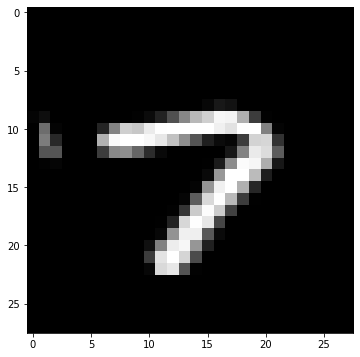

7


In [33]:
print(train_deskewed.shape)

n = 5
showOpencvImage(train_deskewed[n].reshape(28, 28))
print(train_labels[n])

### Support Vector Classifier

In [34]:
from sklearn.svm import SVC

In [35]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Wybór modelu

In [36]:
parameters = {
    'C' : [5*n for n in range(1, 5)],
    'gamma' : [10**(-2*n) for n in range(6)]
}

model = SVC()
clf_svc = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_svc.fit(train_deskewed[:1000], train_labels[:1000])
print(clf_svc.best_params_, clf_svc.best_score_)

{'C': 5, 'gamma': 0.01} 0.9279999999999999


Testowanie wybranego modelu

In [37]:
model = clf_svc.best_estimator_
model = model.fit(train_deskewed[:50000], train_labels[:50000])

pred_labels = model.predict(train_deskewed[50000:])

mask = pred_labels==train_labels[50000:]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(train_labels[50000:], pred_labels)
print(cm)
print(classification_report(train_labels[50000:], pred_labels))

98.37
[[ 977    0    0    0    1    0    2    1    1    1]
 [   0 1077    0    0    1    0    0    1    0    2]
 [   2    0  991    1    5    1    0    5    4    0]
 [   0    1    9  963    0    2    0    0    6    2]
 [   1    3    2    0  938    0    3    0    1    7]
 [   0    0    1    6    2  903    5    0    1    2]
 [   2    1    0    0    2    5 1028    0    2    0]
 [   2    3    5    2    4    1    0 1044    1    3]
 [   1    1    1    3    1    6    2    4  955    2]
 [   3    1    1    3    6    5    0    6    2  961]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.99      1.00      0.99      1081
           2       0.98      0.98      0.98      1009
           3       0.98      0.98      0.98       983
           4       0.98      0.98      0.98       955
           5       0.98      0.98      0.98       920
           6       0.99      0.99      0.99      1040
           7       0.98      0

### Random Forest Classifier

Wybór modelu

In [38]:
parameters = {
    'max_depth' : [4**n for n in range(1, 5)],
    'max_features' : [10*n for n in range(1, 5)]
}
model = RandomForestClassifier()
clf_rfc = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_rfc.fit(train_deskewed[0:1000], train_labels[0:1000])
print(clf_rfc.best_params_, clf_rfc.best_score_)

{'max_depth': 16, 'max_features': 40} 0.9400000000000001


Testowanie modelu

In [39]:
model = clf_rfc.best_estimator_
model = model.fit(train_deskewed, train_labels)

pred_labels = model.predict(test_deskewed)

mask = pred_labels==test_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

96.22
[[ 974    0    0    0    0    0    2    1    3    0]
 [   0 1117    5    2    0    0    2    1    8    0]
 [   7    0 1002    8    1    0    0    5    9    0]
 [   1    2    8  972    0    8    0    4    9    6]
 [   4    1    3    0  893    0    6    2   10   63]
 [   5    0    0   20    1  851    3    2    7    3]
 [   8    4    0    1    2    1  935    0    6    1]
 [   3    5    7    3    0    0    0  991    4   15]
 [   5    4    6    6    2    1    5    1  941    3]
 [   5    7    1   16    7    2    1   10   14  946]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.96      0.95      1010
           4       0.99      0.91      0.95       982
           5       0.99      0.95      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0

## Sieć neuronowa

Wybór modelu

In [44]:
def create_network():
  network = Sequential()
  network.add(Dense(512, activation='relu', input_shape=(28*28,)))
  network.add(Dense(10, activation='softmax'))
  network.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return network

model = KerasClassifier(build_fn = create_network, epochs=5, verbose=0)

parameters = {
    'batch_size' : [4**n for n in range(1, 6)]
}

grid = GridSearchCV(model, parameters, scoring='accuracy', cv=StratifiedKFold())
grid_result = grid.fit(train_deskewed[:10000], train_labels[:10000])
print(grid_result.best_params_, grid_result.best_score_)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'batch_size': 16} 0.9605


Trening i testowanie modelu

In [50]:
network = create_network()
network.fit(train_deskewed, encoded_train_labels, epochs=5, batch_size=16)

Epoch 1/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.2503 - accuracy: 0.9264
Epoch 2/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0914 - accuracy: 0.9756
Epoch 3/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0702 - accuracy: 0.9831
Epoch 4/5
3750/3750 [==============================] - 17s 5ms/step - loss: 0.0606 - accuracy: 0.9857
Epoch 5/5
3750/3750 [==============================] - 17s 5ms/step - loss: 0.0543 - accuracy: 0.9883


In [51]:
test_loss, test_acc = network.evaluate(test_deskewed, encoded_test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 27.3928 - accuracy: 0.9816
test_acc: 0.9815999865531921


In [52]:
pred_probabilities = network.predict(test_deskewed)
pred_labels = np.argmax(pred_probabilities,-1)

In [53]:
cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))

[[ 974    0    1    0    0    0    4    1    0    0]
 [   0 1124    2    2    0    2    3    0    2    0]
 [   4    2 1012    0    1    0    1    1   11    0]
 [   1    0    7  985    0    6    0    2    8    1]
 [   0    0    4    0  963    0    5    0    0   10]
 [   3    0    0    3    0  872    9    0    3    2]
 [   2    2    0    0    1    0  950    0    2    1]
 [   2    4    9    3    5    0    1  989    4   11]
 [   3    0    3    0    2    1    0    1  962    2]
 [   1    5    1    4    7    2    1    2    1  985]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.96   

Wyniki eksperymentu:


*   SVC: 98.37%
*   Las losowy: 96.22%
*   Sieć neuronowa: 98.16%

Wyniki dla wszystkich modeli są podobne do wyników z poprzedniego zadania, kolejność danych nie wpływa na wyniki nauczania.
